In [1]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# some matrics and stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew

In [3]:
# Replace PATH_TO_ROOT

import sys
PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/City-Scale-Electricity-Use-Prediction'
sys.path.insert(0,PATH_TO_ROOT)

In [4]:
def generate_fig_path(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/section4.1 model comparison/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    '''
    Generate the path to input data
    '''
    return '{}/results/data/predict/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    '''
    Generate the path to save the result data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

In [5]:
cities = ['Los Angeles', 'Sacramento', 'New York']

In [6]:
def combine_predict(region):
    lgbm_predict = pd.read_csv(generate_input_data_path(f'lgbm_{region}'),index_col=0)[['yhat_lgbm']]
    otherML_predict = pd.read_csv(generate_input_data_path(f'otherML_{region}'),index_col=0)[['yhat_rf','yhat_svm','yhat_nn']]
    linear_predict = pd.read_csv(generate_input_data_path(f'linear_{region}'),index_col=0)[['y','yhat_hcdh','yhat_5p']]
    prophet_predict = pd.read_csv(generate_input_data_path(f'prophet_{region}'),index_col=0)[['yhat_prophet','train']]

    predict = pd.concat([lgbm_predict, otherML_predict, linear_predict, prophet_predict], axis=1)
    predict.index = pd.to_datetime(predict.index)

    predict.rename(columns={'y':'Ground Truth',
                            'yhat_5p':'5-Parameter',
                            'yhat_hcdh':'Degree Hour',
                            'yhat_prophet':'Decomposed',
                            'yhat_lgbm':'lightGBM',
                            'yhat_rf':'Random Forest',
                            'yhat_svm':'Support Vector Machine',
                            'yhat_nn':'Neural Network'}, inplace=True)
    return predict

In [7]:
la_predict = combine_predict('la')
sac_predict = combine_predict('sac')
ny_predict = combine_predict('ny')

In [8]:
def calculate_error(predict):
    accCom = pd.DataFrame(columns=['R2_train','R2_test','MAE_train','MAE_test','RMSE_train','RMSE_test',
                                   'CVRMSE_train','CVRMSE_test'])
    accCom['R2_train'] = predict[predict['train']].loc[:,['Ground Truth','5-Parameter','Degree Hour','Decomposed',
                        'lightGBM','Random Forest','Support Vector Machine','Neural Network']].corr().iloc[0,1:]
    accCom['R2_test'] = predict[~predict['train']].loc[:,['Ground Truth','5-Parameter','Degree Hour','Decomposed',
                        'lightGBM','Random Forest','Support Vector Machine','Neural Network']].corr().iloc[0,1:]

    train_real = predict[predict['train']]['Ground Truth'].values
    test_real = predict[~predict['train']]['Ground Truth'].values
    for predict_field in accCom.index:
        train_predict = predict[predict['train']][predict_field].values
        test_predict = predict[~predict['train']][predict_field].values
        accCom.loc[predict_field,'MAE_train'] = mean_absolute_error(train_real, train_predict)
        accCom.loc[predict_field,'MAE_test'] = mean_absolute_error(test_real, test_predict)
        accCom.loc[predict_field,'RMSE_train'] = mean_squared_error(train_real, train_predict)**0.5
        accCom.loc[predict_field,'CVRMSE_train'] = accCom.loc[predict_field,'RMSE_train']/predict['Ground Truth'].mean()
        accCom.loc[predict_field,'RMSE_test'] = mean_squared_error(test_real, test_predict)**0.5
        accCom.loc[predict_field,'CVRMSE_test'] = accCom.loc[predict_field,'RMSE_test']/predict['Ground Truth'].mean()
    
    accCom.drop(['R2_train','R2_test'], axis=1, inplace=True)
    
    return accCom

In [9]:
la_error = calculate_error(la_predict)
sac_error = calculate_error(sac_predict)
ny_error = calculate_error(ny_predict)

In [12]:
error_result = pd.concat([la_error, sac_error, ny_error], keys=cities)
error_result.to_csv(generate_result_data_path('Table 3'))

In [18]:
error_result

MAE_train   MAE_test RMSE_train  \
Los Angeles 5-Parameter              3.006622   4.968567   4.083289   
            Degree Hour              3.720241   5.268949   4.744226   
            Decomposed               2.581685   3.970039   3.448111   
            lightGBM                 1.990927   4.156334   2.678491   
            Random Forest            2.229979   4.600818   3.075336   
            Support Vector Machine   2.164858   4.433023   3.193093   
            Neural Network           2.848277   5.010833   3.657369   
Sacramento  5-Parameter               2.04316   2.251871   2.789458   
            Degree Hour              2.489977   2.660192   3.323469   
            Decomposed                2.27928   3.434393   2.990501   
            lightGBM                 1.424089   1.691321   2.028057   
            Random Forest            1.519839   2.010575   2.128335   
            Support Vector Machine    1.48466   1.688178   2.307214   
            Neural Network           1.740556   2.079388   2.387664   
New York    5-Parameter             14.783038  17.357908  20.258166   
            Degree Hour             15.029674  17.895908  20.834821   
            Decomposed              16.890623  20.917021   22.41824   
            lightGBM                 9.741732  13.261019  13.608847   
            Random Forest           11.389763  16.248654  15.589183   
            Support Vector Machine  16.682057  20.417426  26.726674   
            Neural Network           11.19659  14.051201  15.197511   

                                    RMSE_test CVRMSE_train CVRMSE_test  
Los Angeles 5-Parameter              6.383493      0.05248    0.082043  
            Degree Hour               6.85083     0.060974    0.088049  
            Decomposed               5.338005     0.044316    0.068606  
            lightGBM                 5.061207     0.034425    0.065048  
            Random Forest            5.695959     0.039525    0.073206  
            Support Vector Machine   5.531595     0.041039    0.071094  
            Neural Network           6.073147     0.047006    0.078054  
Sacramento  5-Parameter              2.952581     0.058158    0.061559  
            Degree Hour               3.34332     0.069292    0.069706  
            Decomposed               4.264957      0.06235    0.088922  
            lightGBM                 2.205806     0.042284     0.04599  
            Random Forest            2.678019     0.044374    0.055835  
            Support Vector Machine   2.131471     0.048104     0.04444  
            Neural Network           2.510488     0.049781    0.052342  
New York    5-Parameter             22.565612     0.046594    0.051901  
            Degree Hour             23.221754      0.04792     0.05341  
            Decomposed              27.157614     0.051562    0.062463  
            lightGBM                17.845176     0.031301    0.041044  
            Random Forest           21.855684     0.035855    0.050268  
            Support Vector Machine  31.797675     0.061472    0.073135  
            Neural Network          18.675701     0.034954    0.042954

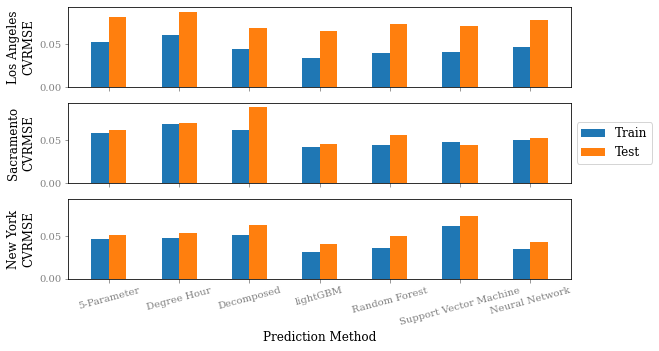

In [21]:
width = 0.25  # the width of the bars

fig, axes = plt.subplots(3, 1, sharex=True,sharey=True, figsize=(9,5))

for i, region in zip(range(3), ['Los Angeles', 'Sacramento', 'New York']):

    labels = error_result.loc[region,:].index
    CVRMSE_train = error_result.loc[region,'CVRMSE_train']
    CVRMSE_test = error_result.loc[region,'CVRMSE_test']

    x = np.arange(len(labels))  # the label locations
    

    rects1 = axes[i].bar(x - width/2, CVRMSE_train, width, label='Train')
    rects2 = axes[i].bar(x + width/2, CVRMSE_test, width, label='Test')

    axes[i].set_ylabel(f'{region}\nCVRMSE')
    
axes[2].set_xlabel('Prediction Method')
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels, rotation=15)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(generate_fig_path('Figure 16'))

In [11]:
plot_time = {'summer':['2018-07-01','2018-10-01'], 'winter':['2018-12-31','2019-04-01']}

la_predict_plot = la_predict.drop(['train'], axis=1)
sac_predict_plot = sac_predict.drop(['train'], axis=1)
ny_predict_plot = ny_predict.drop(['train'], axis=1)

data_all = [la_predict_plot,sac_predict_plot,ny_predict_plot]
cities = ['Los Angeles', 'Sacramento', 'New York']


In [12]:
import matplotlib.dates as mdates

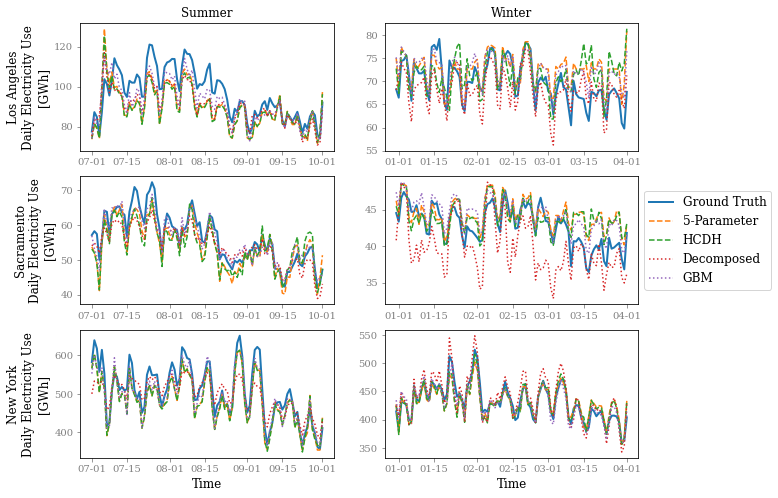

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10,8))
myFmt = mdates.DateFormatter('%m-%d')

for index in range(3):
    data = data_all[index]
    city = cities[index]
    data_summer = data.truncate(before=plot_time['summer'][0], after=plot_time['summer'][1])
    data_winter = data.truncate(before=plot_time['winter'][0], after=plot_time['winter'][1])
    
    axes[index, 0].plot(data_summer.index, data_summer['Ground Truth'].values, label='Ground Truth', linewidth=2)
    axes[index, 0].plot(data_summer.index, data_summer['5-Parameter'].values, '--', label='5-Parameter')
    axes[index, 0].plot(data_summer.index, data_summer['Degree Hour'].values, '--', label='HCDH')
    axes[index, 0].plot(data_summer.index, data_summer['Decomposed'].values, ':', label='Decomposed')
    axes[index, 0].plot(data_summer.index, data_summer['lightGBM'].values, ':', label='GBM')
    axes[index, 0].xaxis.set_major_formatter(myFmt)

    axes[index, 1].plot(data_winter.index, data_winter['Ground Truth'].values, label='Ground Truth', linewidth=2)
    axes[index, 1].plot(data_winter.index, data_winter['5-Parameter'].values, '--', label='5-Parameter')
    axes[index, 1].plot(data_winter.index, data_winter['Degree Hour'].values, '--', label='HCDH')
    axes[index, 1].plot(data_winter.index, data_winter['Decomposed'].values, ':', label='Decomposed')
    axes[index, 1].plot(data_winter.index, data_winter['lightGBM'].values, ':', label='GBM')
    axes[index, 1].xaxis.set_major_formatter(myFmt)
    
    axes[index, 0].set_ylabel(f'{city}\nDaily Electricity Use\n[GWh]')

axes[1, 1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0, 0].set_title('Summer')
axes[0, 1].set_title('Winter')
axes[2, 0].set_xlabel('Time')
axes[2, 1].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure 15'))